In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.listdir('../input/ranzcr-clip-catheter-line-classification/')

['train_tfrecords',
 'sample_submission.csv',
 'train_annotations.csv',
 'test_tfrecords',
 'train.csv',
 'test',
 'train']

In [3]:
train = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/train.csv')
test = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/sample_submission.csv')
train_annotations = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/train_annotations.csv')

# delete suspicious data
train = train[train['StudyInstanceUID'] != '1.2.826.0.1.3680043.8.498.93345761486297843389996628528592497280'].reset_index(drop=True)
train_annotations = train_annotations[train_annotations['StudyInstanceUID'] != '1.2.826.0.1.3680043.8.498.93345761486297843389996628528592497280'].reset_index(drop=True)

## Directory settings

In [4]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

#TRAIN_PATH = '../input/ranzcr-512x512-dataset'
# TRAIN_PATH = '../input/ranzcr-640x640-dataset'
TRAIN_PATH = '../input/ranzcr-clip-catheter-line-classification/train'

## CFG

In [5]:
# ======================================================
# CFG 
# ======================================================
class CFG:
    debug=True
    print_freq=100
    num_workers=4
    model_name='vit_base_patch16_224'
    size=672
    scheduler='CosineAnnealingLR'
    epochs=6
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=6 # CosineAnnealingLR
    #T_0=6 # CosineAnnealingWarmRestarts
    lr = 5e-5
    min_lr=1e-6
    batch_size=8
    weight_decay=1e-6
    gradient_accumulation_step=1
    max_grad_norm= 1000
    seed=42
    target_size=11
    target_cols=['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
                 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal', 
                 'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal',
                 'Swan Ganz Catheter Present']
    n_fold=4
    trn_fold=[0]
    train=True
    
if CFG.debug:
    CFG.epochs = 3
    train = train.sample(n=3000, random_state=CFG.seed).reset_index(drop=True)

## Library

In [6]:
# ======================================================
# Library
# ======================================================
import sys
sys.path.append('../input/pytorch-image-models/')

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

from torch.cuda.amp import autocast, GradScaler

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Utils

In [7]:
# ===================================================
# Utils
# ===================================================
def get_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:, i], y_pred[:, i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f}s.')
    
def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch(seed=42)

## CV split

In [8]:
folds = train.copy()
Fold = GroupKFold(n_splits=CFG.n_fold)
groups = folds['PatientID'].values
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_cols], groups)):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
display(folds.groupby('fold').size())

fold
0    750
1    750
2    750
3    750
dtype: int64

## Dataset

In [9]:
# ======================================================
# Dataset
# ======================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['StudyInstanceUID'].values
        self.labels = df[CFG.target_cols].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}.jpg'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).float()
        return image, label

## Transforms

In [10]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            Resize(CFG.size, CFG.size), 
            RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)), 
            HorizontalFlip(p=0.5), 
            Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
            ), 
            ToTensorV2(),
        ])
    
    elif data == 'valid':
        return Compose( [
            Resize(CFG.size, CFG.size), 
            Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
            ), 
            ToTensorV2(),
            
        ])

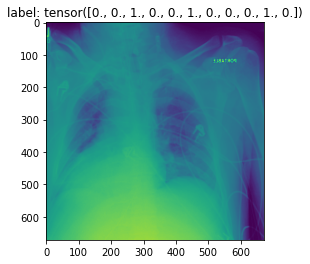

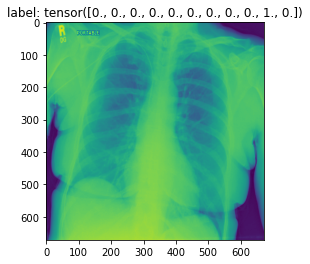

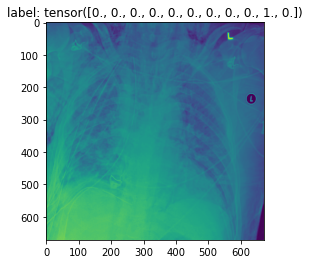

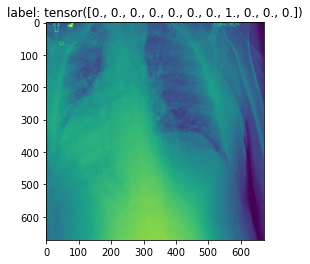

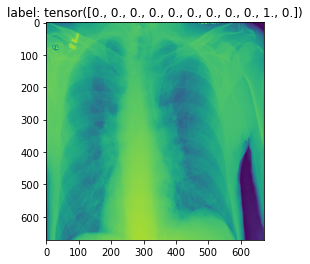

In [11]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(5):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show()

In [12]:
# =================================================
# MODEL
# =================================================
class Custom_ViT(nn.Module):
    def __init__(self, model_name, pretrained=False, att_activate=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.head.in_features
        self.model.head = nn.Identity()
        if att_activate:
            self.att_layer = nn.Sequential(
                nn.Linear(n_features, 256), 
                nn.Tanh(), 
                nn.Linear(256, 1), 
            )
        else: 
            self.att_layer = nn.Linear(n_features, 1)
                
        self.head = nn.Linear(n_features, CFG.target_size)
            
    def forward(self, x):
        l = x.shape[2] // 3
        h1 = self.model(x[:, :, :l, :l])
        h2 = self.model(x[:, :, :l, l:l*2])
        h3 = self.model(x[:, :, :l, l*2:l*3])
        h4 = self.model(x[:, :, l:l*2, :l])
#         h5 = self.model(x[:, :, l:l*2, l:l*2])
#         h6 = self.model(x[:, :, l:l*2, l*2:l*3])
#         h7 = self.model(x[:, :, l*2:l*3, :l])
#         h8 = self.model(x[:, :, l*2:l*3, l:l*2])
#         h9 = self.model(x[:, :, l*2:l*3, l*2:l*3])

        a1 = self.att_layer(h1)
        a2 = self.att_layer(h2)
        a3 = self.att_layer(h3)
        a4 = self.att_layer(h4)
#         a5 = self.att_layer(h5)
#         a6 = self.att_layer(h6)
#         a7 = self.att_layer(h7)
#         a8 = self.att_layer(h8)
#         a9 = self.att_layer(h9)

        w = F.softmax(torch.cat([a1, a2, a3, a4], dim=1), dim=1)

        h = h1 * w[:, 0].unsqueeze(-1) + h2 * w[:, 1].unsqueeze(-1) + h3 * w[:, 2].unsqueeze(-1) + h4 * w[:, 3].unsqueeze(-1)

        output = self.head(h)
        return output

In [13]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / percent
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (images, labels) in pbar:
        # msasure data loading time 
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with autocast():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_step > 1:
            loss = loss / CFG.gradient_accumulation_steps
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_step == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evalutation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = label.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.gradient_accumulation_step > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [17]:
# ===================================================
# Train loop
# ===================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")
    
    # =========================================================
    # loader
    # =========================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
    
    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_cols].values
    
    train_dataset = TrainDataset(train_folds, transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='valid'))
    
    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers,
                              pin_memory=True, 
                              drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, 
                              pin_memory=True, 
                              drop_last=False)
    
    # =====================================================
    # scheduler
    # =====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler
    
    # =====================================================
    # model & optimizer
    # =====================================================
    model = Custom_ViT(CFG.model_name, pretrained=True)
    model.to(device)
    
    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)
    
    # =====================================================
    # loop
    # =====================================================
    criterion = nn.BCEWithLogitsLoss()
    
    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
        
        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
        
        # scoreing
        score, scores = get_score(valid_labels, preds)
        
        elapsed = time.time() - start_time
        
        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f} avg_val_loss: {avg_val_loss:.4f} time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f} Scores: {np.round(scores, decimals=4)}')
        
        """
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
        """
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds}, 
                       OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
            
        # save all models
        torch.save({'model': model.state_dict()}, 
                   OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_epoch{epoch+1}.pth')
            
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    for c in [f'pred_{c}' for c in CFG.target_cols]:
        valid_folds[c] = np.nan
    valid_folds[[f'pred_{c}' for c in CFG.target_cols]] = check_point['preds']
    
    return valid_folds

In [18]:
# =====================================================
# main
# =====================================================
def main():
    """
    Prepare: 1.train 2.folds
    """
    
    def get_result(result_df):
        preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
        labels = result_df[CFG.target_cols].values
        score, scores = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f} Scores: {np.round(scores, decimals=4)}')
        
    if CFG.train:
        # train
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f'========== fold: {fold} result ==========')
                get_result(_oof_df)
        
        # CV result
        LOGGER.info(f'========== CV ==========')
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [19]:
if __name__ == '__main__':
    main()

========== fold: 0 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch: [1][0/281] Data 2.006 (2.006) Elapsed 0m 4s (remain 20m 3s) Loss: 0.7839(0.7839) Grad: 230194.0938  
Epoch: [1][100/281] Data 0.003 (0.025) Elapsed 1m 17s (remain 2m 18s) Loss: 0.1954(0.2880) Grad: 48634.1758  
Epoch: [1][200/281] Data 0.003 (0.015) Elapsed 2m 31s (remain 1m 0s) Loss: 0.2970(0.2718) Grad: 82823.1953  
Epoch: [1][280/281] Data 0.002 (0.012) Elapsed 3m 29s (remain 0m 0s) Loss: 0.2668(0.2647) Grad: 85410.2266  
EVAL: [0/47] Data 4.559 (4.559) Elapsed 0m 5s (remain 3m 59s) Loss: 0.2149(0.2149) 


Epoch 1 - avg_train_loss: 0.2647 avg_val_loss: 0.2392 time: 254s
Epoch 1 - Score: 0.7953 Scores: [0.9346 0.9234 0.9577 0.823  0.7875 0.8871 0.9164 0.539  0.5654 0.5406
 0.8737]
Epoch 1 - Save Best Loss: 0.2392 Model


EVAL: [46/47] Data 0.000 (0.527) Elapsed 0m 44s (remain 0m 0s) Loss: 0.2887(0.2392) 


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch: [2][0/281] Data 2.115 (2.115) Elapsed 0m 3s (remain 14m 18s) Loss: 0.1948(0.1948) Grad: 42785.3945  
Epoch: [2][100/281] Data 0.004 (0.027) Elapsed 1m 17s (remain 2m 17s) Loss: 0.1947(0.2304) Grad: 50915.1250  
Epoch: [2][200/281] Data 0.008 (0.016) Elapsed 2m 30s (remain 0m 59s) Loss: 0.2961(0.2267) Grad: 56675.2734  
Epoch: [2][280/281] Data 0.002 (0.013) Elapsed 3m 29s (remain 0m 0s) Loss: 0.1742(0.2272) Grad: 51871.2188  
EVAL: [0/47] Data 4.407 (4.407) Elapsed 0m 4s (remain 3m 43s) Loss: 0.2111(0.2111) 


Epoch 2 - avg_train_loss: 0.2272 avg_val_loss: 0.2309 time: 254s
Epoch 2 - Score: 0.7996 Scores: [0.8785 0.9234 0.9711 0.8205 0.8278 0.9102 0.9308 0.5418 0.5844 0.5305
 0.876 ]
Epoch 2 - Save Best Loss: 0.2309 Model


EVAL: [46/47] Data 0.000 (0.532) Elapsed 0m 44s (remain 0m 0s) Loss: 0.2747(0.2309) 


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch: [3][0/281] Data 2.057 (2.057) Elapsed 0m 2s (remain 13m 29s) Loss: 0.2492(0.2492) Grad: 77103.4062  
Epoch: [3][100/281] Data 0.004 (0.026) Elapsed 1m 16s (remain 2m 16s) Loss: 0.1969(0.2217) Grad: 69241.3906  
Epoch: [3][200/281] Data 0.002 (0.016) Elapsed 2m 30s (remain 0m 59s) Loss: 0.1842(0.2200) Grad: 57193.6211  
Epoch: [3][280/281] Data 0.002 (0.013) Elapsed 3m 28s (remain 0m 0s) Loss: 0.1770(0.2153) Grad: 41194.9727  
EVAL: [0/47] Data 3.794 (3.794) Elapsed 0m 4s (remain 3m 14s) Loss: 0.2184(0.2184) 


Epoch 3 - avg_train_loss: 0.2153 avg_val_loss: 0.2244 time: 253s
Epoch 3 - Score: 0.8096 Scores: [0.8985 0.9344 0.9758 0.8275 0.8433 0.9168 0.9315 0.5406 0.5888 0.5296
 0.9188]
Epoch 3 - Save Best Loss: 0.2244 Model


EVAL: [46/47] Data 0.000 (0.522) Elapsed 0m 43s (remain 0m 0s) Loss: 0.2502(0.2244) 


========== fold: 0 result ==========
Score: 0.8096 Scores: [0.8985 0.9344 0.9758 0.8275 0.8433 0.9168 0.9315 0.5406 0.5888 0.5296
 0.9188]
========== CV ==========
Score: 0.8096 Scores: [0.8985 0.9344 0.9758 0.8275 0.8433 0.9168 0.9315 0.5406 0.5888 0.5296
 0.9188]
